In [2]:
import numpy as np 
import matplotlib.pyplot as plt

samples = [[80, 144, +1], [93, 232, +1], [136, 275, -1], [147, 131, -1], [159, 69, +1],\
           [214, 31, +1], [214, 152, -1], [257, 83, +1], [307, 62, -1], [307, 231, -1]]

%matplotlib inline

In [3]:
def loadSimpData(): 
    classLabels = [1,1,-1,-1,1,1,-1,1,-1,-1]
    datMat = np.matrix([[80, 144], [93, 232], [136, 275], [147, 131], [159, 69],\
           [214, 31], [214, 152], [257, 83 ], [307, 62], [307, 231]])
    return datMat, classLabels

datMat, classLabels = loadSimpData() 

In [4]:
def showScatter(matrix, labels,line): 
    plt.figure(figsize=(8,6)) 
    x1 = []; y1 = []; x2 = []; y2 = [] 
    for i in range(len(labels)): 
        if labels[i] == 1.0: 
            x1.append(matrix[i, 0]) 
            y1.append(matrix[i, 1]) 
        else: 
            x2.append(matrix[i, 0]) 
            y2.append(matrix[i, 1]) 
    plt.scatter(x1, y1, marker='o', color='green', alpha=0.7, label='1.0') 
    plt.scatter(x2, y2, marker='^', color='red', alpha=0.7, label='-1.0')
    
    if len(line) > 0:
        if line['dim'] == 0:
            plt.axvline(line['thresh'])
        else:
            plt.axhline(line['thresh'])
    
    plt.title('dataset') 
    plt.ylabel('variable Y') 
    plt.xlabel('Variable X') 
    plt.legend(loc='upper right') 
    plt.show()

In [5]:
def adaClassify(datToClass, classifierArr): 
    dataMatrix = np.mat(datToClass) 
    m = np.shape(dataMatrix)[0] 
    aggClassEst = np.mat(np.zeros((m, 1))) # 为了满足输出期望，先用0列向量初始化输出结果 
    
    #print("aggClassEst:")
    #print(aggClassEst)
    #print("m:")
    #print(m)
    
    for i in range(len(classifierArr)): 
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq']) # 得到一个弱分类器分类结果
        
        #print("classEst:")
        #print(classEst)
        
        
        aggClassEst += classifierArr[i]['alpha'] * classEst # 对应算法流程的步骤7，将弱分类器结果加权求和 
        
        #print("aggClassEst:")
        #print(aggClassEst)
        
    return np.sign(aggClassEst) #由于是二类问题，所以可以根据加权求和结果的正负情况得到期望的分类输出 

In [6]:
# dataMatirx：要分类的数据 
# dimen：维度 
# threshVal：阈值 
# threshIneq：有两种，‘lt’=lower than，‘gt’=greater than 
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq): 
    retArray = np.ones((np.shape(dataMatrix)[0], 1))
    if threshIneq == 'gt': 
        retArray[dataMatrix[:, dimen] <= threshVal] = 1.0 # 如果希望大于阈值的是1，则小于阈值的部分置为-1 
    else: 
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0 
    #print(dataMatrix)
    #print(retArray)
    #print('end')
    return retArray 


In [7]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40): 
    weakClassArr = [] 
    m = np.shape(dataArr)[0] 
    D = np.mat(np.ones((m,1)) / m) # 初始化权重向量，给每个样本相同的权重，[[1/m],[1/m],[1/m],...] 
    aggClassEst = np.mat(np.zeros((m,1))) # 初始化每个样本的预估值为0 
    for i in range(numIt): # 遍历迭代次数 
        bestStump, error, classEst = buildStump(dataArr, classLabels, D) # 构建一棵单层决策树，返回最好的树，错误率和分类结果
        
        showScatter(datMat,classLabels,bestStump)
        
        alpha = float(0.5 * np.log((1.0 - error)/error)) #计算分类器权重 
        bestStump['alpha'] = alpha #将alpha值也加入最佳树字典 
        weakClassArr.append(bestStump) # 将弱分类器加入数组 
        # print("classEst:", classEst.T) 
        # 更新权重向量D 
        expon = np.multiply(-1*alpha*np.mat(classLabels).T, classEst) 
        D = np.multiply(D, np.exp(expon)) 
        D = D / D.sum() # 累加错误率，直到错误率为0或者到达迭代次数 
        aggClassEst += alpha * classEst 
        #print("aggClassEst:", aggClassEst.T) 
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1))) 
        errorRate = aggErrors.sum() / m 
        #print("total error:", errorRate, "\n") 
        if errorRate == 0.0: 
            break; 
    return weakClassArr 


In [8]:
# dataArr: 数据集 
# classLabels：标签 
# D：由每个样本的权重构成的矩阵 
def buildStump(dataArr, classLabels, D): 
    dataMatrix = np.mat(dataArr) 
    labelMat = np.mat(classLabels).T # 标签转成列向量 
    m, n = np.shape(dataMatrix) #m为数据个数，n为每条数据含有的样本数（也就是特征） 
    numSteps = 10.0 
    bestStump = {} 
    bestClasEst = np.mat(np.zeros((m, 1))) # 初始化最好的分类器为[[0],[0],[0],...] 
    minError = np.inf #最小错误率，不停更新最小错误率 
    for i in range(n): #遍历特征 
        rangeMin = dataMatrix[:, i].min(); # 找这一列特征的最小值 
        rangeMax = dataMatrix[:, i].max(); # 找这一列特征的最大值 
        stepSize = (rangeMax - rangeMin) / numSteps #每次移动的步长 
        for j in range(-1, int(numSteps) + 1): #对每个步长 
            for inequal in ['lt', 'gt']: # 每个条件，大于阈值是1还是小于阈值是1 
                threshVal = (rangeMin + float(j) * stepSize) # 阈值设为最小值+第j个步长 
                #print('i=%d, threshVal=%f, inequal=%s'%(i,threshVal,inequal)) 
                predictedVals = stumpClassify(dataMatrix, i , threshVal, inequal) # 将dataMatrix的第i个特征inequal阈值的置为1，否则为-1 
                #print(predictedVals) 
                errArr = np.mat(np.ones((m, 1))) 
                errArr[predictedVals == labelMat] = 0 # 预测对的置0 
                #print(errArr) 
                weightedError = D.T * errArr 
                #print("split: dim %d, threshold %.2f, threshold inequal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)) 
                if weightedError < minError: 
                    minError = weightedError 
                    bestClasEst = predictedVals.copy() 
                    bestStump['dim'] = i 
                    bestStump['thresh'] = threshVal 
                    bestStump['ineq'] = inequal 
    return bestStump, minError, bestClasEst


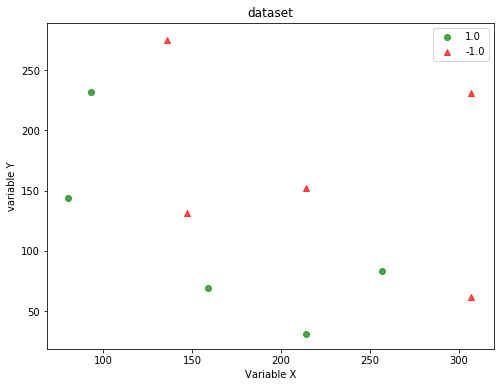

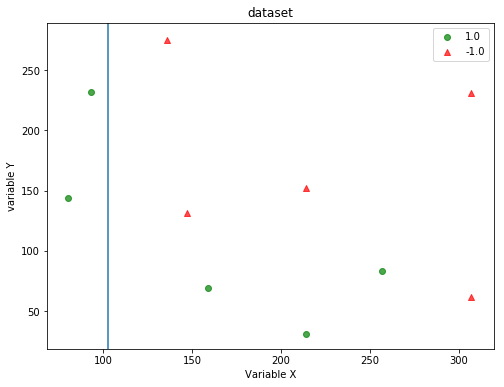

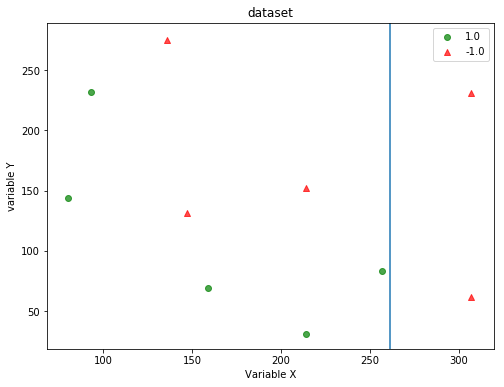

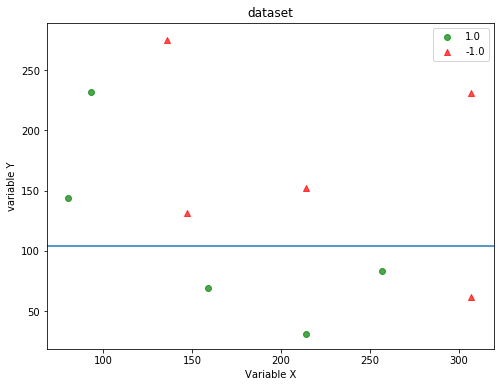

predict : 
[[ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]]
classLabels :
[1, 1, -1, -1, 1, 1, -1, 1, -1, -1]
weak classifiers:
{'dim': 0, 'thresh': 102.7, 'ineq': 'lt', 'alpha': 0.4236489301936017}
{'dim': 0, 'thresh': 261.6, 'ineq': 'lt', 'alpha': 0.6496414920651304}
{'dim': 1, 'thresh': 104.19999999999999, 'ineq': 'lt', 'alpha': 0.9229133452491652}


In [10]:
showScatter(datMat, classLabels,{})
classifierArray = adaBoostTrainDS(datMat,classLabels)
result = adaClassify(datMat,classifierArray)
print('predict : ');
print(result)
print('classLabels :')
print(classLabels)
print('weak classifiers:')
for signle in classifierArray:
    print(signle)